# On Vectorization

---

## <a id="Contents"></a>   Contents

- [Core](#Core)
- [Numerical solution: basic update scheme](#Numerical-solution:-basic-update-scheme)
- [Numerical solution: vectorized update scheme](#Numerical-solution:-vectorized-update-scheme)
- [Results summary](#Results-summary)

---

## <a id ="Core"></a>   Core

In [1]:
import matplotlib, numpy, os, pickle, time
from matplotlib import colors as mcolors
from matplotlib import pyplot

# Import custom utility module
import sys
sys.path.insert(1, "../utility")
from utils import SimulationData, build_banded_matrix

%matplotlib inline

In [2]:
# Initialize data
data = SimulationData(
    R=3e-3, L=1e-3, G=1e-2, C=1e3,
    X=1.0, T=1.0, num_x_points=100, num_t_points=1000,
    mu_0 = lambda x : numpy.sin(5*numpy.pi*x) + 2*numpy.sin(7*numpy.pi*x),
    xi_0 = 0.,
    nu_0 = lambda t : 0., nu_X = lambda t : 0.,
    name="experiment_01"
)
print(f"CFL number = {data.get_CFL_number()}\n")

Line parameters initialized.
Domain parameters initialized.
CFL number = 0.09909909909909909



In [3]:
# Experiment parameters
num_x_points = [int(100*i) for i in [1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25]]
num_t_points = [int(1000*i) for i in [1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25]]
num_runs = 20
runtimes = numpy.zeros((len(num_x_points),num_runs))
save_dir = "./"

[Back to Contents](#Contents)

---

## <a id="Numerical-solution:-basic-update-scheme"></a>   Numerical solution: basic update scheme

In [4]:
# Run experiment
for i, (K_plus_1, N_plus_1) in enumerate(zip(num_x_points, num_t_points)):
    print(f">> Simulating with K = {K_plus_1-1} and N = {N_plus_1-1}")
    # Set data
    data.set_domain(num_x_points=K_plus_1, num_t_points=N_plus_1)
    print(f"  CFL number = {data.get_CFL_number()}")

    # Update scheme parameters
    A = 1. + 0.5 * data.domain["t step"] * (data.line["alpha"] + data.line["beta"])
    B = 1. - 0.5 * data.domain["t step"] * (data.line["alpha"] + data.line["beta"])
    E = data.line["c squared"] * data.domain["t step"]**2 / data.domain["x step"]**2
    F = 2. - (2. * data.line["c squared"] * data.domain["t step"]**2 / data.domain["x step"]**2) - (data.line["alpha"] * data.line["beta"] * data.domain["t step"]**2)

    # Get discretized domains
    x_domain = data.get_x_domain()
    t_domain = data.get_t_domain()
    
    for j in range(num_runs):
        print(f"Run no. {j+1}...", end="")
        
        # Initialize container for voltages
        u = numpy.zeros((data.domain["K"]+1, data.domain["N"]+1))
        
        # Start counter
        tic = time.perf_counter()
        
        # Initial conditions
        u[:,0] = data.init_condition_value(x_domain)
        u[0,0] = data.dirichlet_sending_end(t_domain[0])
        u[-1,0] = data.dirichlet_receiving_end(t_domain[0])
        u[:,1] = data.init_condition_deriv(u[:,0])
        u[0,1] = data.dirichlet_sending_end(t_domain[1])
        u[-1,1] = data.dirichlet_receiving_end(t_domain[1])

        # n=1,2,...,N-1
        for n in range(1,data.domain["N"]):
            # k=1,2,...,K-1
            for k in range(1,data.domain["K"]):
                u_was, u_now = u[k,n-1], u[k,n]
                u_now_left, u_now_right = u[k-1,n], u[k+1,n]
                u_nxt = E*u_now_left + F*u_now + E*u_now_right - B*u_was
                u_nxt /= A
                u[k,n+1] = u_nxt
            # k=0, K
            u[0,n+1] = data.dirichlet_sending_end(t_domain[n+1])
            u[-1,n+1] = data.dirichlet_receiving_end(t_domain[n+1])
        
        # Stop counter
        toc = time.perf_counter()
        
        # Record elapsed time
        runtimes[i,j] = toc-tic
        print(f"completed in {toc-tic} seconds.")

del A, B, E, F
del x_domain, t_domain
del i, K_plus_1, N_plus_1
del j, u, tic, toc
del n, k, u_was, u_now, u_now_left, u_now_right, u_nxt

>> Simulating with K = 99 and N = 999
Domain parameters 'K' and 'x step' are adjusted.
Domain parameters 'N' and 't step' are adjusted.
  CFL number = 0.09909909909909909
Run no. 1...completed in 0.22315210000000008 seconds.
Run no. 2...completed in 0.21473799999999965 seconds.
Run no. 3...completed in 0.2127902000000006 seconds.
Run no. 4...completed in 0.20765419999999946 seconds.
Run no. 5...completed in 0.20813260000000078 seconds.
Run no. 6...completed in 0.22565529999999967 seconds.
Run no. 7...completed in 0.2234892000000004 seconds.
Run no. 8...completed in 0.23172179999999987 seconds.
Run no. 9...completed in 0.23457550000000005 seconds.
Run no. 10...completed in 0.22585820000000023 seconds.
Run no. 11...completed in 0.23518930000000005 seconds.
Run no. 12...completed in 0.22884740000000026 seconds.
Run no. 13...completed in 0.21029330000000002 seconds.
Run no. 14...completed in 0.22427310000000045 seconds.
Run no. 15...completed in 0.2150002999999998 seconds.
Run no. 16...com

In [5]:
# Save results
with open(os.path.join(save_dir, "basic-update-scheme.pkl"), 'wb') as file:
    pickle.dump(runtimes, file)
print("Runtime results saved to " + os.path.join(save_dir, "basic-update-scheme.pkl") + ".")
del file

Runtime results saved to ./basic-update-scheme.pkl.


[Back to Contents](#Contents)

---

## <a id="Numerical-solution:-vectorized-update-scheme"></a>   Numerical solution: vectorized update scheme

In [4]:
# Run experiment
for i, (K_plus_1, N_plus_1) in enumerate(zip(num_x_points, num_t_points)):
    print(f">> Simulating with K = {K_plus_1-1} and N = {N_plus_1-1}")
    # Set data
    data.set_domain(num_x_points=K_plus_1, num_t_points=N_plus_1)
    print(f"  CFL number = {data.get_CFL_number()}")

    # Update scheme parameters
    A = 1. + 0.5 * data.domain["t step"] * (data.line["alpha"] + data.line["beta"])
    B = 1. - 0.5 * data.domain["t step"] * (data.line["alpha"] + data.line["beta"])
    E = data.line["c squared"] * data.domain["t step"]**2 / data.domain["x step"]**2
    F = 2. - (2. * data.line["c squared"] * data.domain["t step"]**2 / data.domain["x step"]**2) - (data.line["alpha"] * data.line["beta"] * data.domain["t step"]**2)
    E_matrix = build_banded_matrix(numpy.array([E, F, E]), data.domain["K"]-1)
    B_matrix = B*numpy.concatenate(
        (numpy.zeros((data.domain["K"]-1,1)), numpy.identity(data.domain["K"]-1), numpy.zeros((data.domain["K"]-1,1))),
        axis=1
    )

    # Get discretized domains
    x_domain = data.get_x_domain()
    t_domain = data.get_t_domain()
    
    for j in range(num_runs):
        print(f"Run no. {j+1}...", end="")
        
        # Initialize container for voltages
        u = numpy.zeros((data.domain["K"]+1, data.domain["N"]+1))
        
        # Start counter
        tic = time.perf_counter()
        
        # Initial conditions
        u[:,0] = data.init_condition_value(x_domain)
        u[0,0] = data.dirichlet_sending_end(t_domain[0])
        u[-1,0] = data.dirichlet_receiving_end(t_domain[0])
        u[:,1] = data.init_condition_deriv(u[:,0])
        u[0,1] = data.dirichlet_sending_end(t_domain[1])
        u[-1,1] = data.dirichlet_receiving_end(t_domain[1])

        # n=1,2,...,N-1
        for n in range(1,data.domain["N"]):
            u_was, u_now = u[:,n-1], u[:,n]
            # k=1,2,...,K-1
            tilde_u_nxt = numpy.dot(E_matrix, u_now) - numpy.dot(B_matrix, u_was)
            tilde_u_nxt /= A
            # k=0,1,...,K
            u_nxt = numpy.concatenate(
                (numpy.array([data.dirichlet_sending_end(t_domain[n+1])]),
                 tilde_u_nxt,
                 numpy.array([data.dirichlet_receiving_end(t_domain[n+1])]))
            )
            u[:,n+1] = u_nxt
        
        # Stop counter
        toc = time.perf_counter()
        
        # Record elapsed time
        runtimes[i,j] = toc-tic
        print(f"completed in {toc-tic} seconds.")

del A, B, E, F, E_matrix, B_matrix
del x_domain, t_domain
del i, K_plus_1, N_plus_1
del j, u, tic, toc
del n, u_was, u_now, tilde_u_nxt, u_nxt

>> Simulating with K = 99 and N = 999
Domain parameters 'K' and 'x step' are adjusted.
Domain parameters 'N' and 't step' are adjusted.
  CFL number = 0.09909909909909909
Run no. 1...completed in 0.105302 seconds.
Run no. 2...completed in 0.09372860000000038 seconds.
Run no. 3...completed in 0.09598380000000084 seconds.
Run no. 4...completed in 0.09454090000000015 seconds.
Run no. 5...completed in 0.09588049999999981 seconds.
Run no. 6...completed in 0.09541630000000012 seconds.
Run no. 7...completed in 0.09716680000000011 seconds.
Run no. 8...completed in 0.10083980000000015 seconds.
Run no. 9...completed in 0.10215569999999996 seconds.
Run no. 10...completed in 0.09944509999999962 seconds.
Run no. 11...completed in 0.09869420000000062 seconds.
Run no. 12...completed in 0.09526119999999949 seconds.
Run no. 13...completed in 0.09611319999999957 seconds.
Run no. 14...completed in 0.09669250000000051 seconds.
Run no. 15...completed in 0.09895089999999929 seconds.
Run no. 16...completed i

In [5]:
# Save results
with open(os.path.join(save_dir, "vectorized-update-scheme.pkl"), 'wb') as file:
    pickle.dump(runtimes, file)
print("Runtime results saved to " + os.path.join(save_dir, "vectorized-update-scheme.pkl") + ".")
del file

Runtime results saved to ./vectorized-update-scheme.pkl.


[Back to Contents](#Contents)

---

## <a id="Results-summary"></a>   Results summary

In [4]:
# Load runtime results
with open(os.path.join(save_dir, "basic-update-scheme.pkl"), 'rb') as file:
    basic_update_scheme_runtimes = pickle.load(file)

with open(os.path.join(save_dir, "vectorized-update-scheme.pkl"), 'rb') as file:
    vectorized_update_scheme_runtimes = pickle.load(file)

del file

In [5]:
# Calculate average runtimes
mean_basic_update_scheme_runtimes = numpy.mean(basic_update_scheme_runtimes, axis=1)
mean_vectorized_update_scheme_runtimes = numpy.mean(vectorized_update_scheme_runtimes, axis=1)

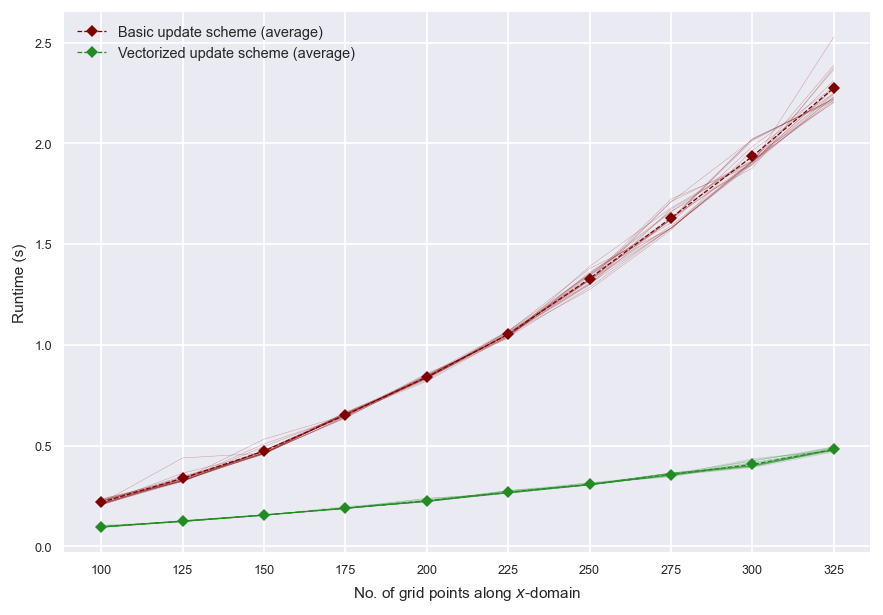

In [6]:
# Plot
matplotlib.style.use("seaborn")

figure = pyplot.figure(dpi=130)
axes = figure.add_subplot(1,1,1)
axes.set_xlabel("No. of grid points along $x$-domain", fontsize=8.5)
axes.set_ylabel("Runtime (s)", fontsize=8.5)
axes.tick_params(labelsize=7)
pyplot.xticks(ticks=num_x_points, labels=[f"{num_x_points[i]}" for i in range(len(num_x_points))])

# Plot individual runtimes
for i in range(num_runs):
    axes.plot(numpy.array(num_x_points), basic_update_scheme_runtimes[:,i], color=mcolors.CSS4_COLORS['maroon'], alpha=0.3, linewidth=0.3)
    axes.plot(numpy.array(num_x_points), vectorized_update_scheme_runtimes[:,i], color=mcolors.CSS4_COLORS['forestgreen'], alpha=0.3, linewidth=0.3)
del i

# Plot average runtimes
axes.plot(numpy.array(num_x_points), mean_basic_update_scheme_runtimes, color=mcolors.CSS4_COLORS['maroon'], marker='D', markersize=5, linestyle='--', linewidth=0.7, label="Basic update scheme (average)")
axes.plot(numpy.array(num_x_points), mean_vectorized_update_scheme_runtimes, color=mcolors.CSS4_COLORS['forestgreen'], marker='D', markersize=5, linestyle='--', linewidth=0.7, label="Vectorized update scheme (average)")

axes.grid(True)
axes.legend(loc="best", fontsize=8);

In [7]:
# Save summary
figure.savefig(os.path.join(save_dir, "runtimes.png"), dpi=300, facecolor=None, edgecolor=None, bbox_inches="tight", pad_inches=0.05)

[Back to Contents](#Contents)

---